In [1]:
import torch
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


def displayDF(train, path, random=False, COLS=6, ROWS=4):
    for k in range(ROWS):
        plt.figure(figsize=(20, 5))
        for j in range(COLS):
            if random:
                row = np.random.randint(0, len(train))
            else:
                row = COLS * k + j
            name = train.iloc[row, 1]
            title = str(train.iloc[row, 3])
            title_with_return = ""
            for i, ch in enumerate(title):
                title_with_return += ch
                if (i != 0) & (i % 20 == 0): title_with_return += '\n'
            img = cv2.imread(str(path / name))
            plt.subplot(1, COLS, j + 1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()

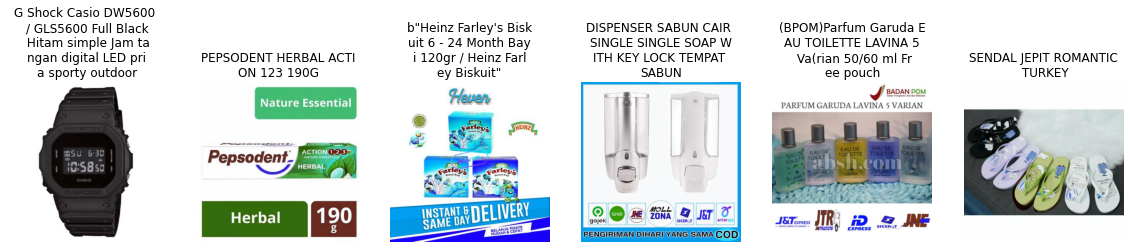

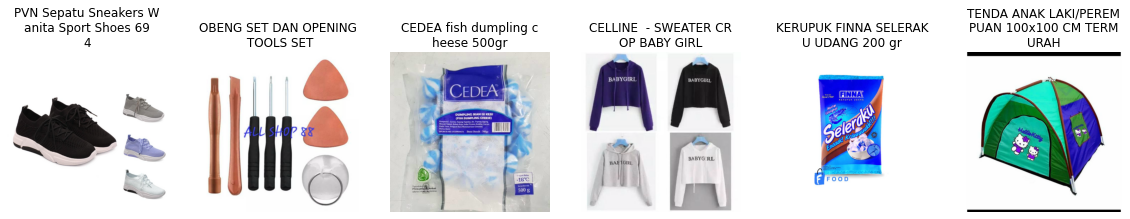

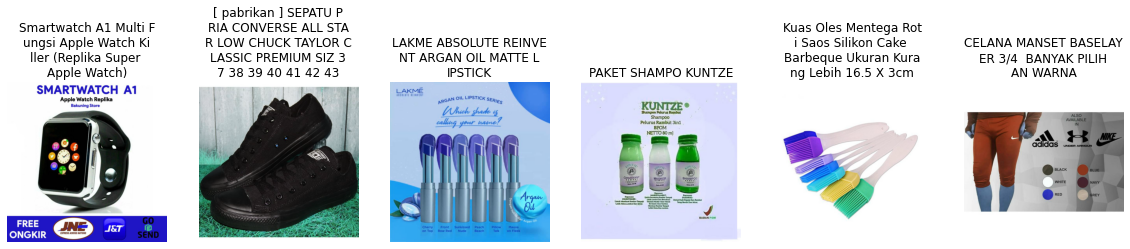

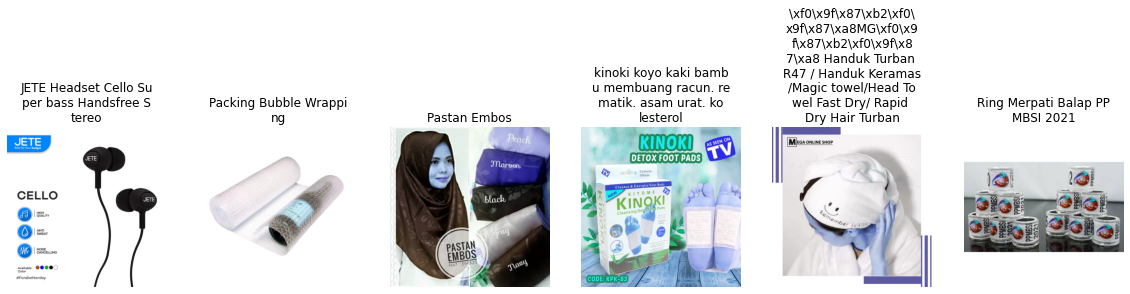

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path = Path.home() / 'OneDrive - Seagroup/computer_vison/shopee_item_images/'
path_img = path / 'train_images'

df = pd.read_csv(path / 'train.csv')

displayDF(df, path=path_img, random=True)

In [3]:
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [4]:
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image, UnidentifiedImageError


model_name = 'efficientnet-b3'
image_size = EfficientNet.get_image_size(model_name)
model = EfficientNet.from_pretrained(model_name)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
print(f'image size: {image_size}, device: {device}')

# transform image
tfms = transforms.Compose([
    transforms.Resize(300),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# image_embedding
image_embedding = {}
for i in tqdm(df['image'].values):
    tmp_path = str(path_img / i)
    try:
        tmp_img = tfms(Image.open(tmp_path).convert('RGB')).unsqueeze(0).to(device)
    except UnidentifiedImageError:
        continue
    with torch.no_grad():
        logits = model(tmp_img)
        image_embedding.update({i: logits})

# save
path_image_embedding = path / 'tensors_b3.pt'
torch.save(image_embedding, path_image_embedding)

Loaded pretrained weights for efficientnet-b3
image size: 300, device: cuda


100%|██████████████████████████████████████████████████████████████████████████| 34250/34250 [2:15:39<00:00,  4.21it/s]
